In [322]:
from os import environ as ENV
import itertools
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import scipy
import pandas as pd

from scipy.interpolate import (
    Akima1DInterpolator, # Akima1D looks the best
    PchipInterpolator,
    CubicSpline, # C1 smooth splines
)

In [2]:
import sys
sys.path.append(ENV['PWD'])

from should_be_stdlib import resample_log

In [3]:
record = scipy.io.loadmat(ENV['HOME'] + '/work/auditory_cortex_data/081920_355r/allPlanesVariables27-Feb-2021.mat')
record.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BFinfo', 'CellInfo', 'CorrInfo', 'allZCorrInfo', 'allxc', 'allyc', 'allzc', 'exptVars', 'selectZCorrInfo', 'stimInfo', 'zDFF', 'zStuff', '__function_workspace__'])

In [4]:
stimInfo = dict(
    zip(
        record['stimInfo'][0][0].dtype.names,
        record['stimInfo'][0][1].squeeze()
    )
)

record['stimInfo'][0][0].dtype.names

('Psignalfile',
 'pfs',
 'PrimaryDuration',
 'PreStimSilence',
 'PostStimSilence',
 'BackgroundNoise',
 'OverallDB',
 'Class',
 'Trialindicies',
 'framespertrial',
 'FreqLevelOrder',
 'Freqs',
 'Levels',
 'uFreqs',
 'uLevels',
 'sessionStartTime',
 'soundTimes')

In [5]:
zStuff = list(
    map(
        lambda r: dict(
            zip(
                record['zStuff'].dtype.names,
                r
            )
        ),
        record['zStuff'].squeeze()[1:]
    )
)

record['zStuff'].dtype.names

('flatFRA',
 'flatTrialFRA',
 'pStim',
 'pTrial',
 'zStimFrame',
 'trialFreq',
 'exptFreq',
 'trialDFF')

In [6]:
[
    old_freqs := resample_log([3, 3*2**4], 9),
    new_freqs := resample_log([3, 3*2**4], 16),
]

[array([ 3.        ,  4.24264069,  6.        ,  8.48528137, 12.        ,
        16.97056275, 24.        , 33.9411255 , 48.        ]),
 array([ 3.        ,  3.60907511,  4.34180771,  5.22330338,  6.28376474,
         7.5595263 ,  9.0942994 , 10.94066986, 13.16189976, 15.83409493,
        19.04881262, 22.91619849, 27.56876052, 33.16590912, 39.89941901,
        48.        ])]

In [7]:
def get_for_planes(datas, indices:range, cols:list[any]|None = None):
    return pd.concat(
        objs = [
            pd.DataFrame(
                data = datas(i),
                columns = cols
            )
            for i in indices
        ],
        keys = [i - min(indices) for i in indices]
    ).rename_axis(['plane', 'idx'])

In [8]:
planes = get_for_planes(
    lambda i: np.array([
        record['allxc'].squeeze()[i].squeeze(),
        record['allyc'].squeeze()[i].squeeze(),
        record['allzc'].squeeze()[i].squeeze(),
    ]).T,
    range(1, len(record['allxc'])),
    ['x', 'y', 'z']
)

In [9]:
fts = get_for_planes(
    lambda i: record['zDFF'][i][0],
    range(1, len(record['zDFF'])),
)

In [10]:
p_stim = get_for_planes(
    lambda i: np.array(zStuff[i]['pStim']),
    range(0, len(zStuff)),
    old_freqs.round(1),
)

In [30]:
sig = (p_stim < 0.01).sum(axis=1) > 0
sigi = sig[sig==True].index
p_stim.loc[sigi].loc[1:]

3.0       4.2       6.0       8.5       12.0      17.0  \
plane idx                                                               
1     3    0.170310  0.312295  0.025202  0.986748  0.012611  0.499344   
      4         NaN  0.746860  0.113030  0.023159  0.004528  0.453314   
      5         NaN  0.441695  0.077101  0.870799  0.003817       NaN   
      6    0.832963       NaN  0.002172  0.041250  0.121483  0.163249   
      7         NaN       NaN  0.300805       NaN  0.006771  0.660074   
...             ...       ...       ...       ...       ...       ...   
5     88   0.496292       NaN  0.069642  0.650147  0.009958  0.379212   
      91   0.596701  0.712251       NaN  0.003269  0.000017  0.061468   
      93        NaN  0.520366       NaN  0.405679  0.000285  0.462349   
      95   0.387588       NaN  0.117262  0.027527  0.394736  0.408863   
      107  0.937493  0.875159  0.977618  0.043698  0.130570  0.000111   

               24.0      33.9      48.0  
plane idx                                
1     3    0.052871  0.616307  0.008132  
      4    0.458606  0.004780       NaN  
      5    0.547808       NaN  0.049366  
      6         NaN       NaN  0.078927  
      7    0.325751       NaN       NaN  
...             ...       ...       ...  
5     88   0.036524  0.222964       NaN  
      91   0.740495  0.271451  0.405679  
      93   0.804207       NaN  0.650147  
      95   0.309005  0.007791       NaN  
      107  0.186456  0.905559  0.489194  

[76 rows x 9 columns]

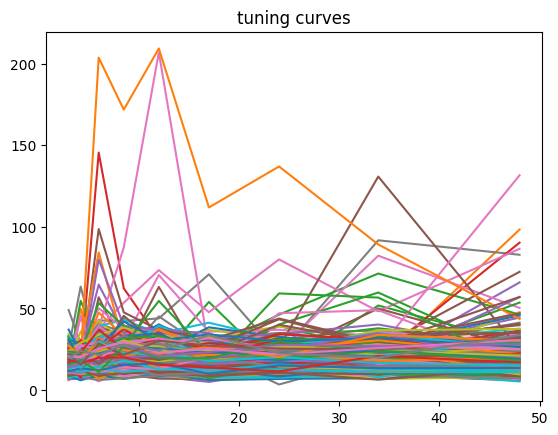

In [12]:
tuning_curves = get_for_planes(
    lambda i: np.array(zStuff[i]['flatFRA']),
    range(0, len(zStuff)),
    old_freqs.round(1),
)

%matplotlib inline
plt.figure()
plt.plot(tuning_curves.T)
plt.title('tuning curves')
plt.show()

In [13]:
tuning_curves_upscaled = tuning_curves.apply(
    lambda response: Akima1DInterpolator(old_freqs, response, method="makima")(new_freqs),
    axis = 1,
    result_type = 'expand',
)
tuning_curves_upscaled.columns = new_freqs.round(1)

In [14]:
tuning_curves_upscaled_normalized = tuning_curves_upscaled.apply(
    lambda response: response / np.linalg.norm(response),
    axis = 1,
    result_type = 'expand',
)

In [15]:
tuning_curves_normalized = tuning_curves.apply(
    lambda response: response / np.linalg.norm(response),
    axis = 1,
    result_type = 'expand',
)

In [16]:
tuning_curves_normalized_upscaled = tuning_curves_normalized.apply(
    lambda response: Akima1DInterpolator(old_freqs, response, method="makima")(new_freqs),
    axis = 1,
    result_type = 'expand',
)
tuning_curves_normalized_upscaled.columns = new_freqs.round(1)

In [17]:
tuning_curves_normalized_upscaled_normalized = tuning_curves_normalized_upscaled.apply(
    lambda response: response / np.linalg.norm(response),
    axis = 1,
    result_type = 'expand',
)

In [497]:
plt.close()
try: ani.event_source.stop()
except: pass

/tmp/uv-cache/archive-v0/8UsHMLKpgIPzMbTbnmWdI/lib/python3.11/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


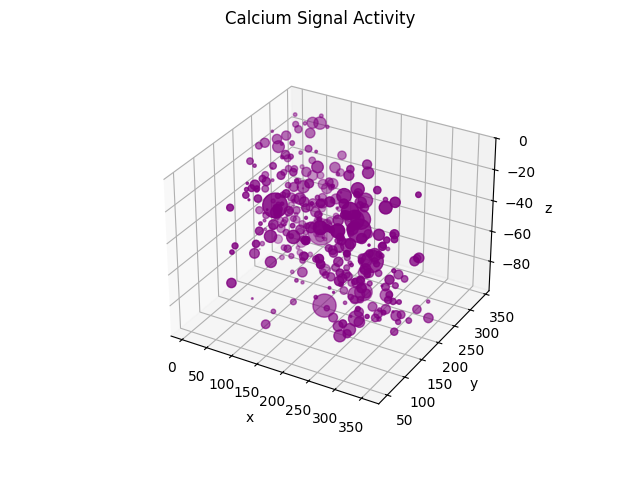

In [287]:
# animated calcium signal data
plt.close()
ps = range(0, 5)

%matplotlib widget
fig = plt.figure(7)
fig.tight_layout()
fig.suptitle('Calcium Signal Activity')
ax = fig.add_subplot(projection='3d')
x, y, z = planes.loc[ps].to_numpy().T

def update(frame):
    ax.clear()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x, y, z, s=fts.loc[ps][frame], c='purple')

update(0)

# ani = animation.FuncAnimation(fig, update, frames=fts.loc[ps].shape[1], interval=1000/30)
# ani.save(ENV['PWD'] + '/data/animated_calcium_signal_data_1-6.mp4')